# Analysis

In [112]:
# Imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split

In [113]:
data = pd.read_csv('data/data.csv')

In [114]:
data.head()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,SP98,cost
0,28.0,5.0,26,21.5,12,0,0,0,0,2.310000
1,12.0,4.2,30,21.5,13,0,0,0,0,0.831600
2,11.2,5.5,38,21.5,15,0,0,0,0,1.016400
3,12.9,3.9,36,21.5,14,0,0,0,0,0.830115
4,18.5,4.5,46,21.5,15,0,0,0,0,1.373625


In [115]:
# Calculate travel costs

# Prices for SP98 and E10 in Spain (bing)
# SP98 => € 1.779
# E10  => € 1.650

data['cost'] = data.apply(lambda row: (row['distance'] / 100) * row['consume'] * (1.779 if row['SP98'] == 1 else 1.650), axis = 1)

data.head()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,SP98,cost
0,28.0,5.0,26,21.5,12,0,0,0,0,2.310000
1,12.0,4.2,30,21.5,13,0,0,0,0,0.831600
2,11.2,5.5,38,21.5,15,0,0,0,0,1.016400
3,12.9,3.9,36,21.5,14,0,0,0,0,0.830115
4,18.5,4.5,46,21.5,15,0,0,0,0,1.373625


In [116]:
# Correlation matrix

data.corr()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,SP98,cost
distance,1.000000,-0.128967,0.562299,0.076930,0.088175,-0.025738,-0.019791,0.081120,-0.053411,0.990060
consume,-0.128967,1.000000,-0.227866,-0.163355,-0.320811,0.096591,0.248118,-0.170667,-0.015327,-0.051835
speed,0.562299,-0.227866,1.000000,0.058990,0.015411,-0.035408,0.009489,0.081618,-0.097360,0.544372
temp_inside,0.076930,-0.163355,0.058990,1.000000,0.362778,0.297473,-0.038523,0.248257,0.004011,0.062500
temp_outside,0.088175,-0.320811,0.015411,0.362778,1.000000,0.167562,-0.186315,0.346903,0.148705,0.041130
AC,-0.025738,0.096591,-0.035408,0.297473,0.167562,1.000000,0.242915,0.088598,0.105285,-0.016781
rain,-0.019791,0.248118,0.009489,-0.038523,-0.186315,0.242915,1.000000,-0.112650,0.060328,0.012447
sun,0.081120,-0.170667,0.081618,0.248257,0.346903,0.088598,-0.112650,1.000000,0.022761,0.066262
SP98,-0.053411,-0.015327,-0.097360,0.004011,0.148705,0.105285,0.060328,0.022761,1.000000,-0.023568
cost,0.990060,-0.051835,0.544372,0.062500,0.041130,-0.016781,0.012447,0.066262,-0.023568,1.000000


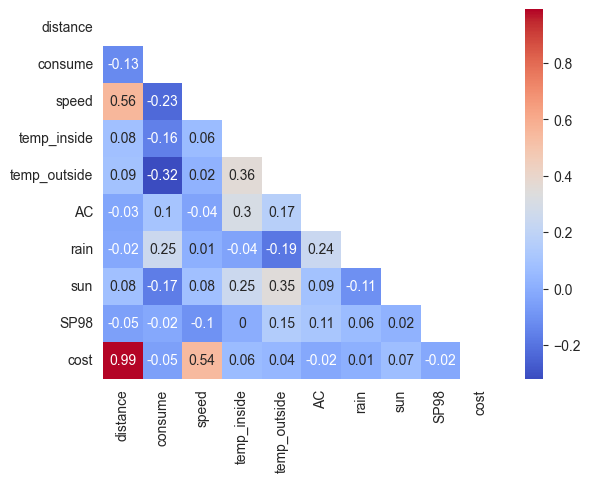

In [117]:
# Correlation heatmap

df = pd.DataFrame(data, columns = data.columns)

mask = np.zeros_like(df.corr(), dtype = 'bool')
mask[np.triu_indices_from(mask)] = True

sns.heatmap(round(df.corr(), 2), annot = True, mask = mask, cmap = 'coolwarm')

plt.show()

## Visualization

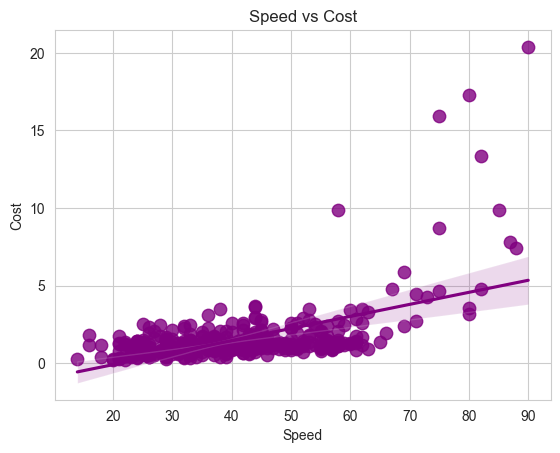

In [118]:
# Does Speed effect our cost per trip? => YES

sns.set_style("whitegrid")
sns.regplot(x = data['speed'], y = data['cost'], data = df, color = 'purple', scatter_kws = {'s': 80})
plt.title("Speed vs Cost")
plt.xlabel("Speed")
plt.ylabel("Cost")
plt.show()

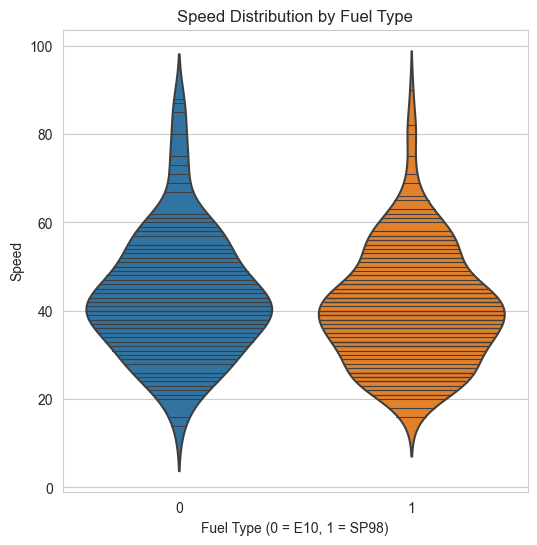

In [119]:
# Does the fuel type effect the speed? ==> NO

df_SP98 = data[data['SP98'] == 1]
df_E10 = data[data['SP98'] == 0]

fig, ax = plt.subplots(figsize=(6, 6))
sns.violinplot(x = 'SP98', y = 'speed', data = df, inner = 'stick', split = True, ax = ax)
ax.set_title('Speed Distribution by Fuel Type')
ax.set_xlabel('Fuel Type (0 = E10, 1 = SP98)')
ax.set_ylabel('Speed')

plt.show()

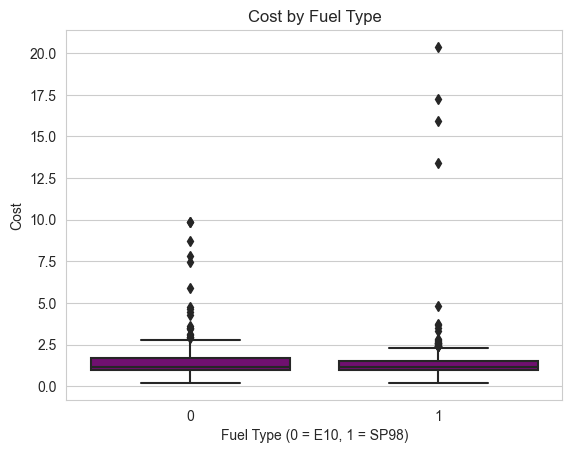

In [120]:
# Does the fuel type effect the costs? ==> Apart from outliers, NO

sns.boxplot(x='SP98', y='cost', data=df, color='purple')
plt.title("Cost by Fuel Type")
plt.xlabel("Fuel Type (0 = E10, 1 = SP98)")
plt.ylabel("Cost")

plt.show()

## Price per km prediction

In [121]:
# SP98 dataset

X_SP98 = data[data['SP98'] == 1].drop('cost', axis = 1)
y_SP98 = data[data['SP98'] == 1]['cost']

In [122]:
# Split the data into training and test sets
X_SP98_train, X_SP98_test, y_SP98_train, y_SP98_test = train_test_split(X_SP98, y_SP98, test_size = 0.2, random_state = 42)

# Train the XGBoost Regressor
reg = xgb.XGBRegressor(n_estimators = 100, learning_rate = 0.1, random_state = 42)
reg.fit(X_SP98_train, y_SP98_train)

# Evaluate the model on the test set
print("Test set R^2: {:.2f}".format(reg.score(X_SP98_test, y_SP98_test)))

Test set R^2: 0.98


In [123]:
# Predict the cost per kilometer (using SP98)

y_pred = reg.predict(X_SP98_test)
cost_per_km_SP98 = y_pred[0] / X_SP98_test.iloc[0, 0]

cost_per_km_SP98

0.0748666769229107

In [124]:
# E10 data set

X_E10 = data[data['SP98'] == 0].drop('cost', axis = 1)
y_E10 = data[data['SP98'] == 0]['cost']

In [125]:
# Split the data into training and test sets
X_E10_train, X_E10_test, y_E10_train, y_E10_test = train_test_split(X_E10, y_E10, test_size = 0.2, random_state = 42)

# Train the XGBoost Regressor
reg = xgb.XGBRegressor(n_estimators = 100, learning_rate = 0.1, random_state = 42)
reg.fit(X_E10_train, y_E10_train)

# Evaluate the model on the test set
print("Test set R^2: {:.2f}".format(reg.score(X_E10_test, y_E10_test)))

Test set R^2: 0.93


In [126]:
# Predict the cost per kilometer (using E10)

y_pred = reg.predict(X_E10_test)
cost_per_km_E10 = y_pred[0] / X_E10_test.iloc[0, 0]

cost_per_km_E10

0.10181011223211521

In [127]:
# Although the price of E10 is cheaper (€1,65), a kilometer driven costs us more (€0,10) than if we had used SP98 (€0,07).